# 电商多轮对话机器人

- 数据集：18年公开的淘宝客服对话数据 https://github.com/cooelf/DeepUtteranceAggregation
- 实现类别：生成式模型
- 模型架构：Seq2Seq模型，编码器使用多层双向GRU,解码器使用多层单向GRU及全局注意力机制，训练模式使用了teacher forcing和梯度修剪技巧，测试模式则使用集束搜索技巧来生成回答
- 依赖：

    - torch 1.0.1
    - jieba 0.38
    - numpy 1.15.4

# 基本准备

In [1]:
import os
import random
import sys
from collections import Counter
import numpy as np
import re
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.nn.functional as F
import jieba
import warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.init()
else:
    device = torch.device('cup')

# 加载和处理数据

- 目的：

    将原始语料中的正确回答的对话段取出，将其处理成 上下文 + '\t' + 回答的格式（多轮对话）的格式，同时统计各词汇的频数

## 查看数据集基本信息

- 原始数据格式

    train.txt:原始对话语料训练集。每一行为 0/1(回答正确与否) + '\t' + 问题1 + '\t' + 回答1 + '\t' + 问题2 + '\t' + 回答2 + '\t' ...**

In [3]:
# 查看文件的前几行
def readline(datafile_dir):
    with open(datafile_dir, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        print("文件共有%s行"%len(lines))
        print("其中前四行为：")
        for line in lines[:4]:
            print(line)

In [4]:
readline('data/train.txt')

文件共有1000000行
其中前四行为：
1	538405926243 买 二份 有没有 少点 呀	亲亲 真的 不好意思 我们 已经 是 优惠价 了 呢 小本生意 请亲 谅解

0	538405926243 买 二份 有没有 少点 呀	恩恩 客官 现在 有个 活动 参加 就 有 礼 哦

1	我 一不小心 就 拍 了 一组 我 在 拍 一组 可以 嘛	要 不亲 退 了 一起 拍 吧	那 就 等 你们 处理 喽	好 的 亲退 了

0	我 一不小心 就 拍 了 一组 我 在 拍 一组 可以 嘛	要 不亲 退 了 一起 拍 吧	那 就 等 你们 处理 喽	亲亲 您 的 订单 今天 五箱 都 会 发货 的 您 看 今天 一起 给 您 发出 可以 吗



## 处理和选择数据

- 处理和选择后:

    multi_train.txt:标准格式的多轮对话语料训练集，只取正确回答的行。每一行为 问题1 + <eos> + 问题2 + <eos> ... + '\t' + 最后一个回答

    vocab.txt:词汇频数字典。

主要步骤：

- 读取数据集，选择其中标签为1的对话
- 将对话中的所有问题作为上下文，问题之间用<eos\>相隔，将最后一个回答作为目标回答，问题和回答之间用\t相隔,同时统计个单词的频数
- 保存处理和选择过的数据集以及词汇频数字典

In [5]:
def preprocess(raw_data_dir, save_dir):
    # 统计数据集中单词频数
    word_count = Counter()
    
    with open(raw_data_dir, 'r', encoding='utf-8') as f, open(save_dir, 'w', encoding='utf-8') as f1:
        for line in f:
            items = line.strip().split('\t') # [标签,问题1,回答1,...]
            if items[0] == '1':              # 只选取其中标记为1的行
                # 更新词汇频数
                words = line.split()[1:]     # 去掉每行开头的标记
                word_count.update(words)     # 向word_count中加入文字，其会自动累计计数
                
                # 生成标准格式的多轮对话数据集
                context = items[1:-1][::2]   # 将所有问题作为上下文
                response = items[-1]
                f1.write(' <eos> '.join(context) + '\t' + response + '\n') # 多个问题之间用 <eos> 隔开
    # 存储频数字典
    torch.save(word_count, 'vocab.txt')
    
    print("处理完成，已生成相应文件")

In [6]:
preprocess('data/train.txt', 'data/multi_train.txt')

处理完成，已生成相应文件


In [7]:
readline('data/multi_train.txt')

文件共有500000行
其中前四行为：
538405926243 买 二份 有没有 少点 呀	亲亲 真的 不好意思 我们 已经 是 优惠价 了 呢 小本生意 请亲 谅解

我 一不小心 就 拍 了 一组 我 在 拍 一组 可以 嘛 <eos> 那 就 等 你们 处理 喽	好 的 亲退 了

那好 的 就 拍 这款 <eos> 颜色 有 这种 <eos> 这个 不是 叫 红色 吗 <eos> 这个 不要 <eos> 俩 和 一 是 一体 的 <eos> 那 我 不 喜欢	颜色 的话 一般 茶刀 茶针 和 二合一 的话 都 是 红木 檀 和 黑木 檀 哦

不是 免 运费	本店 茶具 订单 满 99 包邮除 宁夏 青海 内蒙古 海南 新疆 西藏 满 39 包邮



# 数据预处理

- 过滤问题或回答长度太大的对话
- 过滤含有频数低于阈值的词汇的会话
- 对过滤后的高质量对话进行编码
- 对编码后的对话数据集进行填充

## 创建词汇编码与反编码表

- 创建一个Vov类，包含各类编码表的功能

In [8]:
# 创建一个voc类，用来从给定数据中构建编码表和反编码表,注意voc的实例一开始就需创建，为所有训练/测试数据共用，因而只能有一个
class Voc:
    
    def __init__(self, voc_params):
        # 编码表基本信息
        self.name = voc_params.name                  # voc实例的名称
        self.file_dir = voc_params.file_dir          # 创建voc的数据的位置
        self.vocab_dir = voc_params.vocab_dir        # 创建voc的频数表的位置
        self.save_dir = voc_params.save_dir          # voc的保存位置
        self.trim = voc_params.trim                  # 是否修剪稀有词汇
        self.PAD_token = voc_params.PAD_token        # 填充标记
        self.SOS_token = voc_params.SOS_token        # 句子开头标记
        self.EOS_token = voc_params.EOS_token        # 句子结尾标记
        self.min_count = voc_params.min_count        # 过滤稀有词汇的阈值
        
        # 编码表内容
        self.word2idx = {"<pad>": self.PAD_token, "<sos>": self.SOS_token, "<eos>": self.EOS_token}
        self.word2count = {}
        self.indx2word = {self.PAD_token: "<pad>", self.SOS_token: "<sos>", self.EOS_token: "<eos>"}
        self.num_words = 3   # 编码表所含词汇数,初始时也就是<pad>,<sos>,<eos>三个
        
        # 构建Voc实例
        self.bulidVoc()
        
    # 将句子拆分后加入编码和反编码表                 
    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)
            
    # 将词汇加入编码和反编码表
    def addWord(self, word):
        if word not in self.word2count:
            self.word2idx[word] = self.num_words
            self.word2count[word] = 1
            self.indx2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    # 将句子转换为编码后的序列
    def sentence2sequence(self, sentence):
        return [self.word2idx[word] for word in sentence]
    
    # 将编码的序列反编码为句子
    def sequence2sentence(self, sequence):
        return [self.indx2word[indx] for indx in sequence]
    
    # 构建Voc
    def bulidVoc(self):
        vacab = torch.load(self.vocab_dir)
        with open(self.file_dir, 'r', encoding='utf-8') as f:
            for dialog in f:
                context, target = dialog.strip().split('\t')
                context = context.split()
                target = target.split()
                context_len = len(context)
                target_len = len(target)
                # 过滤含有稀有词的对话
                if not self.trim or (not self.RareWords(context, vacab) and not self.RareWords(target, vacab)):
                    self.addSentence(context)
                    self.addSentence(target)
        # 保存voc
        torch.save(self.__dict__, self.save_dir)

    def RareWords(self, sentence, vocab):
        """
        判断该句子中是否含有频数过低的词汇
        输入:
            sentence:给定句子
            vocab:给定的词汇频数表
        输出：
            True or False
        """
        for word in sentence:
            if vocab[word] < self.min_count and word != '<eos>':   # 由于context中问题之间的分割符为"<eos>"
                return True
        return False

## 数据准备

In [9]:
# 为每个数据集创建一个数据类
class MyDataset(Dataset):
    
    def __init__(self, dataset_params, voc):
        # 基本信息
        self.name = dataset_params.name
        self.voc = voc
        self.file_dir = dataset_params.file_dir                          # 原始数据位置
        self.max_context_len = dataset_params.max_context_len            # 上下文长度阈值
        self.max_target_len = dataset_params.max_target_len              # 目标长度阈值
        
        # 初始化数据集的内容
        self.contexts = []
        self.targets = []
        self.contexts_lens = []
        self.targets_lens = []
        self.dialog_num = 0
        
        # 加载数据
        self.loadData()
        
    def loadData(self):
        with open(self.file_dir, 'r', encoding='utf-8') as f:
            for dialog in f:
                context, target = dialog.strip().split('\t')
                context = context.split()
                target = target.split()
                context_len = len(context)
                target_len = len(target)
                # 丢弃长度不合适的对话
                if 0 < context_len <= self.max_context_len and 0 < target_len <= self.max_target_len:
                    # 丢弃含有voc字典中没有收录的词汇的对话，此即说明对话含有稀有词
                    if not self.has_unknow_word(context) and not self.has_unknow_word(target):
                        # 编码后加入数据列表
                        self.contexts.append(torch.LongTensor([self.voc.SOS_token] + self.voc.sentence2sequence(context) + [self.voc.EOS_token]))
                        self.targets.append(torch.LongTensor([self.voc.SOS_token] + self.voc.sentence2sequence(target) + [self.voc.EOS_token]))
                        self.contexts_lens.append(context_len + 2)
                        self.targets_lens.append(target_len + 2)
                        self.dialog_num += 1
        
    def has_unknow_word(self, sentence):
        for word in sentence:
            if word not in self.voc.word2idx:
                return True
        return False
    
    # 该方法可使数据集通过切片的形式获得第idx个样本
    def __getitem__(self, idx):
        sample = {'context': self.contexts[idx], 'target': self.targets[idx],
                 'context_len': self.contexts_lens[idx], 'target_len': self.targets_lens[idx]}
        return sample

# Seq2Seq模型

模型包含：

- 编码器架构
- 注意力权重计算方式
- 解码器结构
- 训练方法
- 使用Beam Search 对输入的单句话生成和搜索最优回答

总体架构：

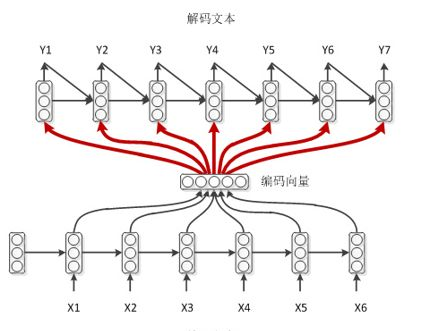

图片来源：https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1553790594467&di=57b521eda3ec02835c0bb4b93baf2f62&imgtype=0&src=http%3A%2F%2Fimage.mamicode.com%2Finfo%2F201805%2F20180526131546738401.png

全局注意力计算方式：

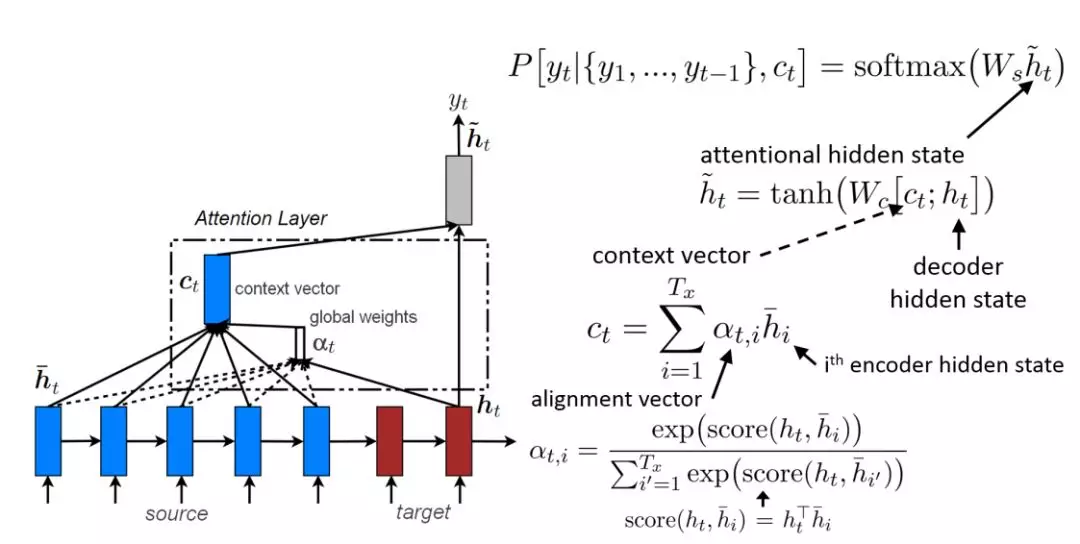

图片来源：https://www.cnblogs.com/databingo/p/9769928.html

编码器计算图：

- 将单词索引转换为词嵌入 embeddings
- 将批次输入序列进行填充
- 为RNN模块压缩已填充批次序列，注意此处需要将序列按长度从大到小排序
- 通过GRU进行前向传播
- 解压批次序列
- 对双向GRU输出求和
- 返回输出和最终隐藏状态

解码器计算图：

- 获取当前输入的词嵌入
- 通过一层dropout层(可选)
- 通过单向GRU进行前向传播(仅向前一个时间步,所以每个样本的长度都为1，就不需要填充压缩了)
- 通过当前GRU的输出和编码器的输出按上图计算注意力权重及后续计算

训练方法：

- 先对输入序列和目标序列进行一定处理
- 将输入序列通过编码器向前传播计算
- 初始化解码器后每次一时间步地通过解码器向前传播计算
- 每次将解码器的输出和目标输出序列进行计算得到当前损失并累加(注意，本次处理中目标序列的填充部分不进行损失的计算)
- 输出损失

集束搜索步骤：

- 先类似训练步骤通过编码器和解码器进行向前传播计算
- 候选列表为同一时刻只有beam_size个元素的list，每个元素也为一个长度为三的list，第一个为当前得分(softmax的log累加分数),第二个为选择的输出序列，第三个为当前隐藏状态张量
- 每次分别使用list的各元素计算下一时间步的beam_size个最优方案，得到beam_size * beam_size个方案，再从中选择最优的三个
- 迭代直至设置长度
- 在候选列表中选择得分最高的输出序列并返回

要特别注意计算过程中的度数为1的维数，其易通过某些函数而别消除。本训练每次都按照批数量作为第一个维度，所以要特别注意输入为单样本的情况。

In [10]:
class Seq2SeqModel(nn.Module):
    
    def __init__(self, voc, model_params):
        super(Seq2SeqModel, self).__init__()
        
        self.name = model_params.name
        
        # 共用架构
            ## embedding层
        self.num_embeddings = voc.num_words                      # 嵌入字典的大小,也即所用voc编码表的大小
        self.embedding_dim  = model_params.embedding_dim         # 每个嵌入向量的大小 
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)     # 初始化embedding，后续可能会被加载训练过的embedding参数
        self.hidden_size = model_params.hidden_size              # gru的隐藏状态向量的大小，编码器和解码器
        self.beam_size = model_params.beam_size                  # 集束宽
        self.use_bidirectional = model_params.use_bidirectional  # 编码器是否使用双向GRU
        self.voc = voc                                           # 模型的词嵌入初始化和解码器初始化信息依赖于所给的voc
        
        # 编码器架构
            ## gru层
        self.encoder_num_layers = model_params.encoder_num_layers # 编码器GRU层数
        self.encoder_dropout = model_params.encoder_dropout       # 编码器除最外一层外每层后增加的dropout层的丢失概率
        self.encoder_gru = nn.GRU(self.embedding_dim, self.hidden_size, self.encoder_num_layers,
                                 batch_first=True, dropout=(self.encoder_dropout if self.encoder_num_layers > 1 else 0),
                                 bidirectional=model_params.use_bidirectional)
        
        
        # 解码器架构
            ## embedding层后加一层dropout
        self.decoder_dropout = model_params.decoder_dropout
        self.embedding_dropout = nn.Dropout(self.decoder_dropout)  # 解码器除最外一层外每层后增加的dropout层的丢失概率
            ## gru层
        self.max_target_len = model_params.max_target_len          # 生成的回答的最大长度
        self.decoder_num_layers = model_params.decoder_num_layers  # 解码器GRU层数
        self.decoder_gru = nn.GRU(self.embedding_dim, self.hidden_size, self.decoder_num_layers,
                                 batch_first=True, dropout=(self.decoder_dropout if self.decoder_num_layers > 1 else 0),
                                 )
            ## 结合全局注意力的最终输出层
        self.concat = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.num_embeddings)
    
    # 模型架构
    
        ## 编码器
    def EncoderRNN(self,context_batch, context_batch_lens, h_0=None):
        """
        将一个批次的输入序列通过Encoder架构
        输入：
            context_batch:一个批次的输入序列,其长度已由大到小排序.shape=[context1, context2,...];context1.size=torch.size(num1)
            context_batch_lens:该批次输入序列的长度，已从小到大排序.shape=[num1,num2,...];num1 >= num2 >=...
            h_0:gur层的初始隐藏状态，不提供则默认是零.torch.size(encoder_num_layers * encoder_num_directions, batch_size, hidden_size)
        输出：
            output:编码器GUR网络所有时间步的最后一层输出.torch.size(batch_size, num1, hidden_size)
            h_n:编码器GRU网络的最终隐藏状态张量.torch.size(encoder_num_layers * encoder_num_directions, batch_size, hidden_size)
        """
        # 填充序列
        padded = pad_sequence(context_batch, batch_first=True)    # torch.size(batch_size,num1)
        
        # 将变量移至给定设备
        padded = padded.to(device)
        context_batch_lens = torch.LongTensor(context_batch_lens).to(device)
        
        # embedding
        embedded = self.embedding(padded)                                # torch.size(batch_size,num1,embedding_dim)
        # 压缩序列
        packed = pack_padded_sequence(embedded, context_batch_lens, batch_first=True)
        # 将压缩序列通过编码器gru
        output, h_n = self.encoder_gru(packed,h_0)
        # 解压缩,output中已经有了原序列长度信息，不需再传入
        output, _ = pad_packed_sequence(output, batch_first=True)          # torch.size(batch_size,num1,encoder_num_directions * hidden_size)
        # 将两个方向的输出相加
        output = output[:, :, :self.hidden_size] + output[:, :, self.hidden_size:]
        
        return output, h_n
    
        ## 注意力权重
    def Atten(self, encoder_output, decoder_output):
        """
        计算当前时刻全局注意力权重
        输入：
            encoder_output:编码器所有时间步的最后一层输出.torch.size(batch_size, seq_len, hidden_size)
            decoder_output:当前时间步解码器GRU的最后一层输出.torch.size(batch_size, 1, hidden_size)
        输出：
            attn_weights:当前时间步的注意力权重.torch.size(batch_size,seq_len,1)
        """
        # 计算得分
        attn_energies = torch.sum(encoder_output * decoder_output, dim=2)           # torch.size(batch_size,seq_len)
        # 归一化
        attn_weights = F.softmax(attn_energies, dim=1).unsqueeze(2)   # torch.size(batch_size,seq_len,1)
        
        return attn_weights
    
    
        ## 带注意力计算的解码器
    def AttenDecoderRNN(self, decoder_input, last_hidden, encoder_output):
        """
        计算当前时间步解码器的输出
        输入：
            decoder_input:当前解码器GRU的输入.torch.size(batch_size)
            last_hidden:上一个时间步的隐藏状态张量.torch.size(decoder_num_layers,batch_size,hidden_size)
            encoder_output:编码器所有时间步的最后一层输出.torch.size(batch_size,seq_len,hidden_size)
        输出：
            out:当前时间步的预测输出(softmax分数形式).torch.size(batch_size,num_embeddings)
            hidden:当前时间步解码器GRU的隐藏状态张量.torch.size(decoder_num_layers,batch_size,hidden_size)
        """
        # 将变量移至给定设备
        decoder_input = decoder_input.to(device)
        
        # embedding
        embedded = self.embedding(decoder_input).unsqueeze(1)         # torch.size(batch_size,1,embedding_dim)
        # dropout
        embedded_dropout = self.embedding_dropout(embedded)
        # 通过解码器gru向前计算
        decoder_output, hidden = self.decoder_gru(embedded_dropout, last_hidden)  # torch.size(batch_size,1,hidden_size),torch.size(ecoder_num_layers,batch_size,hidden_size)
        # 计算注意力权重
        attn_weights = self.Atten(encoder_output, decoder_output)    # torch.size(batch_size,seq_len,1)
        # 计算带注意力权重的上下文张量和
        context = torch.sum(attn_weights * encoder_output, dim=1)                 # torch.size(batch_size,hidden_size)
        # 计算最终输出层
        concat_input = torch.cat((decoder_output.squeeze(1), context), 1)         # torch.size(batch_size,hidden_size*2)
        concat_output = self.concat(concat_input).tanh()                          # torch.size(batch_size,hidden_size)
        output = self.out(concat_output)                                          # torch.size(batch_size,num_embeddings)
        # 归一化
        output = F.softmax(output, dim=1)
        return output, hidden
    
    # 训练
    
        ## 损失计算辅助函数
    @staticmethod
    def maskNLLLoss(output, target, mask):
        """
        计算当前时间步该批次输出的mask损失
        输入:
            output:当前时间步模型最终输出.torch.size(batch_size,num_embeddings)
            target:当前时间步目标输出.torch.size(batch_size)
            mask:当前时间步目标输出的掩码.torch.size(batch_size)
        输出:
            loss:当前时间步批次样本的平均损失，已忽略目标输出为<pad>的损失.
            n_Total:当前时间步批次样本目标输出的实际词汇数.
        """
        # 当前时间步目标输出实际的词汇数
        n_Total = mask.sum()
        # 计算交叉熵,由于target并未使用one-hot编码，所有需要自行计算交叉熵
        crossEntropy = -torch.log(torch.gather(output, 1, target.unsqueeze(1)))
        # 丢弃target中<pad>对应位置产生的交叉熵
        loss = torch.masked_select(crossEntropy, mask).mean()
        loss = loss.to(device)
        
        return loss, n_Total.item()
        
    
        ## 训练方法
    def forward(self, context_batch, context_batch_lens, target_batche, optimizer, Train_Params):
        """
        执行训练
        输入：
            context_batch:该批次的输入序列,其长度已由大到小排序.shape=[context1, context2,...];context1.size=torch.size(num1)
            context_batch_lens:该批次输入序列的长度，已从小到大排序.shape=[num1,num2,...];num1 >= num2 >=...
            target_batche:该批次目标输出序列.shape=[target1,target2,...];target1.size=torch.size(x)
            optimizer:优化器
            Train_Params:训练参数实例.
        输出：
            loss_mean:该批次平均加权损失(权数为各时间步目标输出的实际词汇数)
        """
        # 提取参数
        teacher_forcing_ratio = Train_Params.teacher_forcing_ratio
        clip = Train_Params.clip
        
        # 填充目标输出序列并计算其mask
        target_batche = pad_sequence(target_batche, batch_first=True)
        mask = torch.ByteTensor(target_batche >0)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 将变量移至给定设备
        target_batche = target_batche.to(device)
        mask = mask.to(device)
        
        # 初始化变量
        loss = 0
        print_loss = []
        n_totals = 0
        
        # 通过编码器向前传播计算
        encoder_output, encoder_hidden = self.EncoderRNN(context_batch, context_batch_lens)
        
        # 将句子开头的编码作为初始化解码器输入
        decoder_input = torch.LongTensor([self.voc.SOS_token for _ in range(len(target_batche))])
        
        
        # 将解码器的最终隐藏状态张量作为编码器的初始隐藏状态张量
        decoder_hidden = encoder_hidden[:self.decoder_num_layers]
        
        # 决定时间步是否使用teacher forcing技巧
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        # 解码器向前传播计算，每次一个时间步
        for t in range(self.max_target_len):
            # 若当前时间步大于该批次目标序列的最大长度，则退出。因为超出部分也不计算损失
            if t >= target_batche.size(1):
                break
                
            decoder_output, decoder_hidden = self.AttenDecoderRNN(decoder_input, decoder_hidden, encoder_output)
            # 计算当前时间步损失
            mask_loss, n_Total = self.maskNLLLoss(decoder_output, target_batche[:,t], mask[:,t])
            loss += mask_loss
            print_loss.append(mask_loss.item() * n_Total)
            n_totals += n_Total
            
            if use_teacher_forcing:
                # 此时下一时间步的输入为当前时间步的目标输出
                decoder_input = target_batche[:,t]
                
            else:
                # 此时下一时间步的输入使用当前时间步的预测输出
                decoder_input = torch.argmax(decoder_output, dim=1)
                
        # 反向传播
        loss.backward()
        
        # 梯度修剪
        _ = nn.utils.clip_grad_norm_(self.parameters(), clip)
        
        # 参数更新
        optimizer.step()
        
        # 加权损失
        loss_mean = sum(print_loss) / n_totals
        
        return loss_mean
        
    
    # 评估
    
        ## 评估搜索辅助函数
    def BeamSearch(self, encoder_output, Beam, beam_size):
        """
        给定之前时间步选择的token及上一隐藏状态和分数计算当前时间步分数最高的三个输出.
        输入:
            encoder_output:编码器所有时间步的最后一层输出.torch.size(1,seq_len,hidden_size)
            embedding:词嵌入类实例.
            Beam:[scores, tokens, hidden],其中
                score是输出为前t-1时间步输出为tokens的累加对数softmax分数.torch.size(1)
                hidden,为上一时间步的隐藏状态.torch.size(decoder_num_layers,1,hidden_size)
                tokens,前t-1时间步的输出.torch.size(1, t-1)
            beam_size:集束宽.
        输出：
            Beam:含有输出分数最高的beam_size个beam的list.
        """
        scores, tokens, hidden = Beam
        decoder_input = tokens[:, -1]
        
        scores = scores.to(device)
        tokens = tokens.to(device)
        
        Beam = []
        
        # 给定输入token(t-1)和hidden，计算当前时间步的解码器输出
        decoder_output, hidden = self.AttenDecoderRNN(decoder_input, hidden, encoder_output)
        
        # 选择softmax分数最高的beam_size项
        score, token = torch.topk(torch.log(decoder_output), beam_size, dim=1)
        
        for b in range(beam_size):
            # 累加对数softmax分数
                        
            beam = [score[:,b] + scores, torch.cat((tokens, token[:,b].unsqueeze(1)), 1), hidden]
            Beam.append(beam)
        
        return Beam
        
    
    def BeamSearchIters(self, context, context_len):
        """
        使用集束搜索算法选取概率最大的回答
        输入：
            context:输入序列.[torch.size(num1)]
            context_lens:输入序列的长度，[num1]
            embedding:词嵌入类实例.
        输出：
            token_top:分数最高的一个输出序列.torch.size(1, max_target_len)
        """
        # 获取参数
        beam_size = self.beam_size             # 集束宽.当beam_size=1时即变成了贪婪搜索算法
        
        # 通过编码器
        encoder_output, encoder_hidden = self.EncoderRNN(context, context_len)
        # 初始化解码器
        decoder_hidden = encoder_hidden[:self.decoder_num_layers]
        decoder_input = torch.LongTensor([self.voc.SOS_token]).unsqueeze(0)
        
        # 初始化
        beam = [torch.zeros(1), decoder_input, decoder_hidden]
        Beam = []
        for _ in range(beam_size):
            Beam.append(beam)
        
        # 通过解码器迭代，一次输出bean_size个最可能的词汇
        for t in range(self.max_target_len):
            Beam_t = []
            for b in range(beam_size):
                Beam_t = Beam_t + self.BeamSearch(encoder_output, Beam[b], beam_size)
            
            # 在得到的beam_size * beam_size个元素中选取分数最大的前beam_size个
            Beam = sorted(Beam_t, key=lambda x: -x[0])[:beam_size]
        
        
        # 获取分数最大的beam
        beam_top = max(Beam, key=lambda x: x[0])
        
        scores_top, tokens_top, _ = beam_top
        
        return tokens_top

# 迭代训练

In [35]:
def trainIters(train_params, dataset, model, optimizer, start_iteration=None):
    """
    迭代训练
    输入：
        train_params:训练参数
        model.model_name:模型名称.
        model.voc:此次训练的model用的voc实例.注意其与dataset用的voc需一致.
        dataset:此次训练采用的数据集.为nn.DataSet的子类实例.可使用切片和索引取出相应位置的可直接训练的规范格式样本.
        dataset.name:训练数据的名称.
        dataset.dialog_num:训练数据的样本数.
        model:采用的模型.其为nn.Module的子类实例，可调用实现编码器、解码器向前传播计算及向后传播计算返回损失.
        optimizer:优化器.
        train_params.save_dir:此次训练的各超参数、参数、损失值等的保存位置.
        train_params.n_iteration:该次训练的迭代次数
        train_params.batch_size:每批次样本量.
        train_params.print_every:每print_every次迭代就打印出其平均损失.
        train_params.save_every:每save_evety次迭代就保存训练的各类数据.
        start_iteration:本次迭代训练从第几次迭代开始，适用于从中断的训练继续的情况.
    输出：
        
    """
    # 提取参数
    model_name = model.name
    voc = model.voc
    
    corpus_name = dataset.name
    dialog_num = dataset.dialog_num
    
    n_iteration = train_params.n_iteration
    save_dir = train_params.save_dir
    print_every = train_params.print_every
    save_every = train_params.save_every
    batch_size = train_params.batch_size
    
    
    print("初始化")
    print_loss = []
        
    # 若是从之前的中断处继续训练，则迭代次数应该在其基础上累加
    start_iteration = start_iteration + 1 if start_iteration else 1
    
    
    
    print("开始训练")
    for iteration in range(start_iteration, start_iteration + n_iteration):
        # 每次迭代重新生成打乱的数据索引迭代器
        batch_indx_loader = DataLoader(torch.arange(dialog_num), batch_size=batch_size, shuffle=True)
        for batch_indx in batch_indx_loader:
            # 由于后续编码器计算中pack_paded_sequence函数的要求，需根据将输入的context按长度从小到大排序
            sorted_indx = np.argsort([dataset[idx]['context_len'] for idx in batch_indx])[::-1]
            sorted_indx = [batch_indx[idx] for idx in sorted_indx]
            
            # 获取该批次索引对应排序后的数据            
            context_batch = [dataset[idx]['context'] for idx in sorted_indx]
            context_batch_lens = [dataset[idx]['context_len'] for idx in sorted_indx]
            target_batche = [dataset[idx]['target'] for idx in sorted_indx]
            
            # 训练
            loss = model(context_batch, context_batch_lens, target_batche, optimizer, train_params)
            
            print_loss.append(loss)
            
        print_loss = np.average(print_loss)
        
        
        # 打印进度
        if (iteration - start_iteration) % print_every == 0:
            # 计算这期间的平均损失
            print_loss_avg = print_loss / print_every
            print("已迭代次数：{}; 完成进度: {:.1f}%; 近几次迭代的平均损失: {:.4f}".format(iteration - start_iteration +1,
                                                                      (iteration - start_iteration +1)/n_iteration * 100,
                                                                       print_loss_avg))
            print_loss = []
        
        # 保存当前进度
        if (iteration - start_iteration) % save_every == 0:
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(model.encoder_num_layers, model.decoder_num_layers, model.hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            # 保存
            torch.save({
                'iteration': iteration,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': model.embedding.state_dict()
            }, os.path.join(directory, '{}_{}_{:.3f}.tar'.format(iteration, 'checkpoint', print_loss_avg)))

# 评估文本

In [12]:
class EvaluateInput(object):
    """
    接受从键盘端输入的多个问题，处理并通过模型计算生成合适的回答
    """
    
    def __init__(self, model, voc, max_context_len):
        self.model = model
        self.voc = voc
        self.max_context_len = max_context_len
        self.context = []
        self.length = [0]
        self.r = "[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+"  # 需去除的标点符号
    
    def preprocess(self, sentence):
        """
        对输入的问题进行处理
        输入：
            sentence:键盘端的原始输入
        输出：
            context:多个问题合并的标准化输出
            length:长度
        """
        # 去除标点符号及空格
        sentence = re.sub(self.r, "", sentence)
        # 分词
        sentence = jieba.lcut(sentence)
        # 编码
        sentence = self.voc.sentence2sequence(sentence)
        # 将当前输入句子与前几轮的输入(若有的话)合并
        self.context = self.context + sentence + [voc.EOS_token]
        # 若context过长，则删除context中最早的一个问题
        while len(self.context) > self.max_context_len:
            idx = self.context.index(voc.EOS_token)
            self.context = self.context[idx+1:]
            
    def evaluate(self):
        """
        使用给定模型生成合适的回复.
        输入：
            context:上下文向量.list,len=1.
            length:句子长度.list.len=1
        """
        length = [len(self.context)]
        context = [torch.LongTensor(self.context)]
        
        tokens_top = self.model.BeamSearchIters(context, length)
        # tokens解码
        answer = self.voc.sequence2sentence(tokens_top.cpu().squeeze().numpy().tolist())

        return answer
    
    def Input(self):
        """
        对话接口
        """
        while True:
            
            try:
                # 获取输入的句子
                input_sentence = input('亲，请输入您的问题哦：')
                # 检查使用者是否要退出对话
                if input_sentence == 'q' or input_sentence == 'quit':
                    # 清空并退出
                    self.context = []
                    self.length = [0]
                    break
                # 预处理问题
                self.preprocess(input_sentence)
                # 生成回答
                answer = self.evaluate()
                # 格式化并打印出句子
                output_sentence = [word for word in answer if word not in ['<pad>', '<eos>', '<sos>']]
                print('人工智障客服：',' '.join(output_sentence))
            except KeyError:
                print("对不起，您输入的句子含有敏感/未知词，请重新输入。")

# 配置默认参数

## Voc参数

In [13]:
class Voc_Params():
    
    def __init__(self):
        # 设置默认参数
        self.name = 'voc_params'                        # voc实例的名称
        self.file_dir = 'data/multi_train.txt'          # 创建voc的数据的位置
        self.vocab_dir = 'data/vocab.txt'               # 创建voc的频数表的位置
        self.save_dir = 'data/voc.txt'                  # voc的保存位置
        self.trim = True              # 是否修剪稀有词汇
        self.PAD_token = 0            # 填充标记
        self.SOS_token = 1            # 句子开头标记
        self.EOS_token = 2           # 句子结尾标记
        self.min_count = 5           # 过滤稀有词汇的阈值

## 数据集参数

In [14]:
class Dataset_Params():
    
    def __init__(self):
        # 设置默认参数
        self.name = 'dataset'                       # 数据集名称
        self.voc = voc                              # 对数据集进行处理的voc实例
        self.file_dir = 'data/multi_train.txt'      # 原始数据位置
        self.max_context_len = 60                   # 上下文长度阈值
        self.max_target_len = 30                    # 目标长度阈值

## 模型参数

In [15]:
class Model_Params(object):
    
    def __init__(self):
        # 设置默认参数
        self.name = 'seq2seq_model'            # 模型名称
        self.embedding_dim = 100        # 每个嵌入向量的大小 
        self.hidden_size = 50          # gru的隐藏状态向量的大小，编码器和解码器
        self.beam_size = 10             # 集束宽
        self.encoder_num_layers = 1    # 编码器GRU层数
        self.decoder_num_layers = 2    # 解码器GRU层数
        self.encoder_dropout = 0.5     # 编码器除最外一层外每层后增加的dropout层的丢失概率
        self.decoder_dropout = 0.5     # 解码器除最外一层外每层后增加的dropout层的丢失概率
        self.use_bidirectional = True  # 编码器是否使用双向GRU
        self.max_target_len = 30       # 生成的回答的最大长度

# 开始训练

## 从上次中断处继续训练

In [16]:
loadFilename = 'model/118_checkpoint_1.740.tar'  # 上次训练的进度文件保存位置
checkpoint_iter = 118 # 上次训练最后保存文件的的迭代次数

In [19]:
# 若有
if loadFilename:

    # 继续在本机上训练
    checkpoint = torch.load(loadFilename)
    # 若需要切换到cpu上训练
    # checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    model_sd = checkpoint['model']
    optimizer_sd = checkpoint['optimizer']
    embedding_sd = checkpoint['embedding']
    voc_dict = checkpoint['voc_dict']
    start_iteration = checkpoint['iteration'] + 1

## 创建各实例

In [20]:
# 修改参数
#
#
voc_params = Voc_Params()

voc = Voc(voc_params)

In [21]:
# 加载voc参数

if loadFilename:
    voc.__dict__ = voc_dict

In [22]:
# 修改参数
# 
#

dataset_params = Dataset_Params()

dataset = MyDataset(dataset_params, voc)

In [23]:
# 修改参数
#
#

model_params = Model_Params()

model = Seq2SeqModel(voc, model_params)

In [24]:
# 加载模型参数

if loadFilename:
    model.load_state_dict(model_sd)

In [25]:
model.to(device)

Seq2SeqModel(
  (embedding): Embedding(26591, 100)
  (encoder_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (embedding_dropout): Dropout(p=0.5)
  (decoder_gru): GRU(100, 50, num_layers=2, batch_first=True, dropout=0.5)
  (concat): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=26591, bias=True)
)

## 执行训练

In [26]:
# 训练参数
class Train_Params(object):
    
    def __init__(self):
        # 设置默认值
        self.clip = 10                     # 梯度修剪阈值
        self.teacher_forcing_ratio = 0.5  # 每一时间步的编码器使用tearch_forcing的概率
        self.learning_rate = 0.01         # 学习率
        self.n_iteration = 1              # 迭代次数
        self.save_dir = 'model'                # 训练进度保存位置
        self.print_every = 1             # 打印进度的迭代间隔
        self.save_every = 1               # 保存训练进度的迭代间隔
        self.batch_size = 256             # 批大小

In [27]:
train_params = Train_Params()

In [28]:
# 训练模式
model.train()

Seq2SeqModel(
  (embedding): Embedding(26591, 100)
  (encoder_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (embedding_dropout): Dropout(p=0.5)
  (decoder_gru): GRU(100, 50, num_layers=2, batch_first=True, dropout=0.5)
  (concat): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=26591, bias=True)
)

In [29]:
print("初始化优化器..")

初始化优化器..


In [30]:
optimizer = optim.Adam(model.parameters(), lr=train_params.learning_rate)

In [31]:
print("加载优化器进度..")

加载优化器进度..


In [32]:
# 加载进度
if loadFilename:
    optimizer.load_state_dict(optimizer_sd)

In [33]:
print("开始训练...")

开始训练...


In [36]:
trainIters(train_params, dataset, model, optimizer, start_iteration=checkpoint_iter)

初始化
开始训练
已迭代次数：1; 完成进度: 100.0%; 近几次迭代的平均损失: 1.7485


# 运行评估

In [37]:
# 评估模式
model.eval()

Seq2SeqModel(
  (embedding): Embedding(26591, 100)
  (encoder_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (embedding_dropout): Dropout(p=0.5)
  (decoder_gru): GRU(100, 50, num_layers=2, batch_first=True, dropout=0.5)
  (concat): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=26591, bias=True)
)

In [38]:
# 创建评估实例
evaluateInput = EvaluateInput(model, voc, max_context_len=100)

In [41]:
# 开始聊天
evaluateInput.Input()

亲，请输入您的问题哦：quit
